In [1]:
source("../wwa_model-fitting.R")

# Compute SPEI


In [1]:
suppressMessages(library(SPEI))

In [3]:
sapply(c("mswep", "chirps"), function(ds) {
    df = read.csv(paste0("data/", ds, "_ts_monthly.csv"))
    df_ts <- ts(df$pr, start = sapply(strsplit(df$time[1], "-")[[1]], as.integer)[1:2], frequency = 12)
    res_df <- sapply(c(1,3,6,12,24), function(nm) {
        spi_m <- spi(df_ts, scale = nm, ref.start = c(1990,1), ref.end = c(2020,12))
        spi_m$fitted
    })
    write.csv(setNames(data.frame(df$time, res_df), c("time", "spi_1", "spi_3", "spi_6", "spi_12", "spi_24")), file = paste0("data/",ds,"_spi-monthly.csv"), row.names = F)
})

$mswep
NULL

$chirps
NULL

---
# Fitted models

## Precipitation

In [48]:
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]
gmst <- gmst[gmst$year <= 2023,]

df <- merge(gmst, read.csv("ts/pr_annual_box.csv", col.names = c("year", "acp", "chirps", "mswep")))

In [51]:
mdl_acp <- fit_ns("norm", "fixeddisp", df[!is.na(df$acp),], "acp", "gmst", lower = T)
mdl_chirps <- fit_ns("norm", "fixeddisp", df[!is.na(df$chirps),], "chirps", "gmst", lower = T)
mdl_mswep <- fit_ns("norm", "fixeddisp", df[!is.na(df$mswep),], "mswep", "gmst", lower = T)

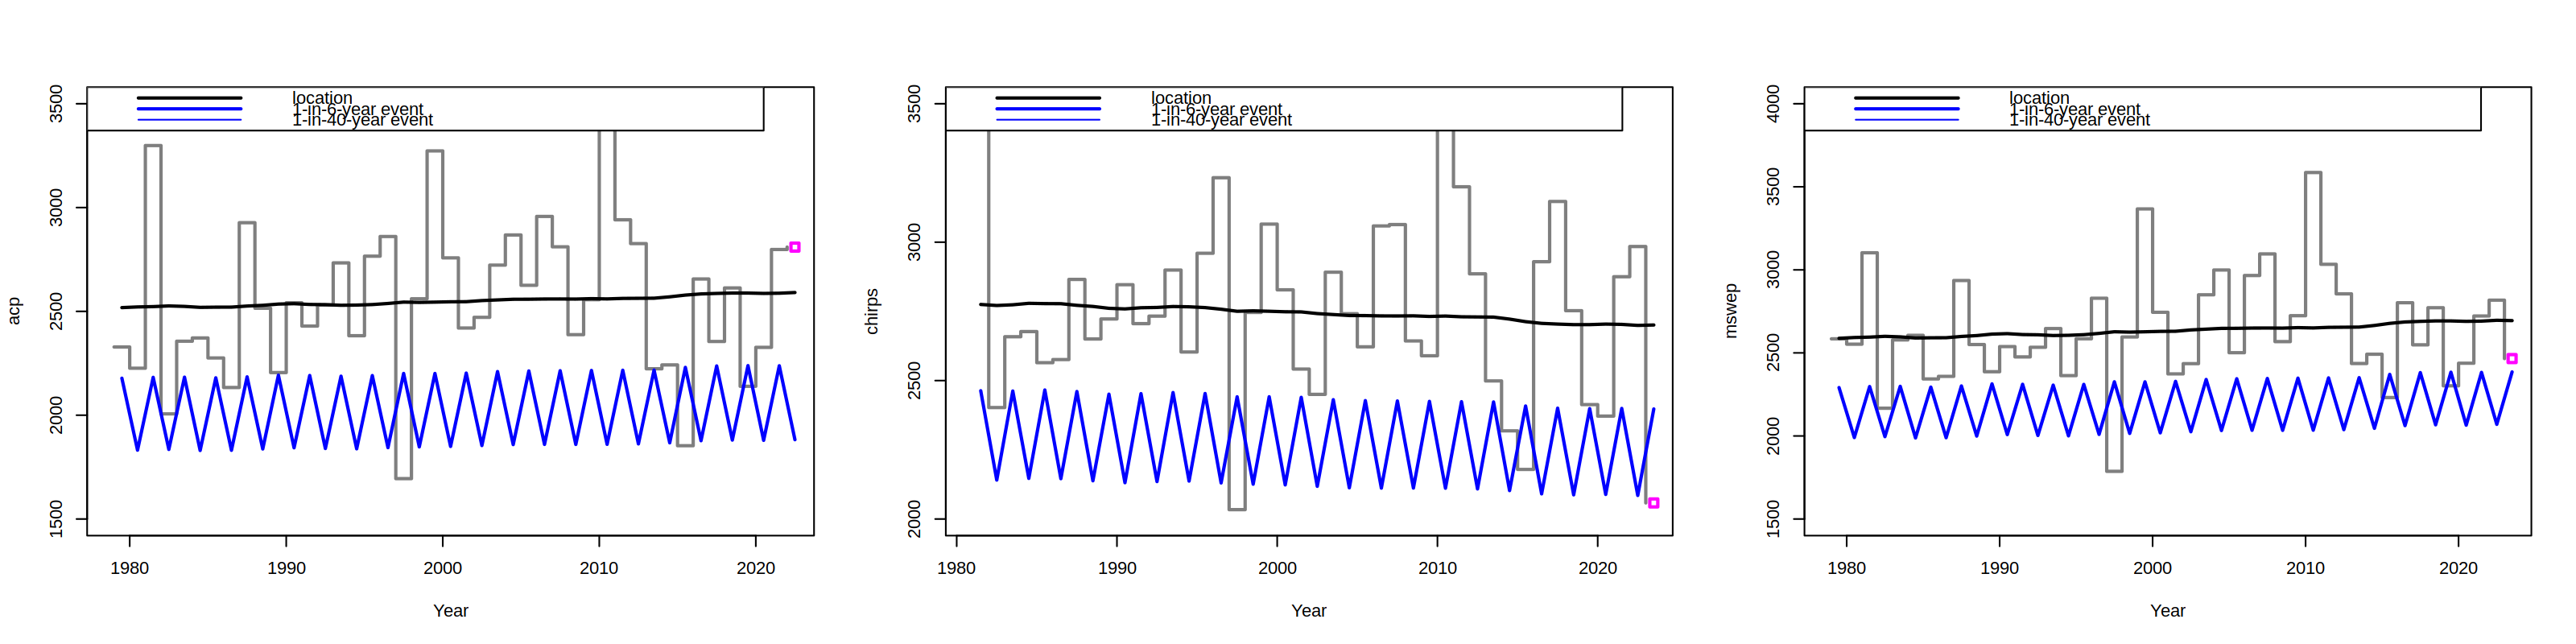

In [52]:
prep_window(c(1,4)); par(mfrow = c(1,3))

plot_trend(mdl_acp)
plot_trend(mdl_chirps)
plot_trend(mdl_mswep)

In [ ]:
res <- abind("acp" = boot_ci(mdl_acp, cov = 0, cov_cf = -1.2),
             "chirps" = boot_ci(mdl_chirps, cov = 0, cov_cf = -1.2),
             "mswep" = boot_ci(mdl_mswep, cov = 0, cov_cf = -1.2), along = 0)

In [54]:
res[,"return_period",]

,bestimate,2.5%,97.5%
acp,1.372224,1.104536,1.956313
chirps,49.530156,13.853787,1087.841488
mswep,4.217537,2.582294,10.827161


In [55]:
res[,"dI_rel",]

,bestimate,2.5%,97.5%
acp,4.345971,-13.507429,24.96644
chirps,-4.331992,-21.293928,13.80888
mswep,6.334587,-6.989652,22.73258


## Onset of rainy season

In [83]:
nino <- load_ts("ts/panama-drought_nino-rel_OND.dat", col.names = c("year", "nino34"))
nino$year <- nino$year + 1

gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
ts <- read.fwf("ts/panama-drought_mswep_rs-onsets.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "var"))

df <- merge(merge(gmst, nino), ts)

In [84]:
lm_both <- lm(var ~ gmst + nino34, data = df)

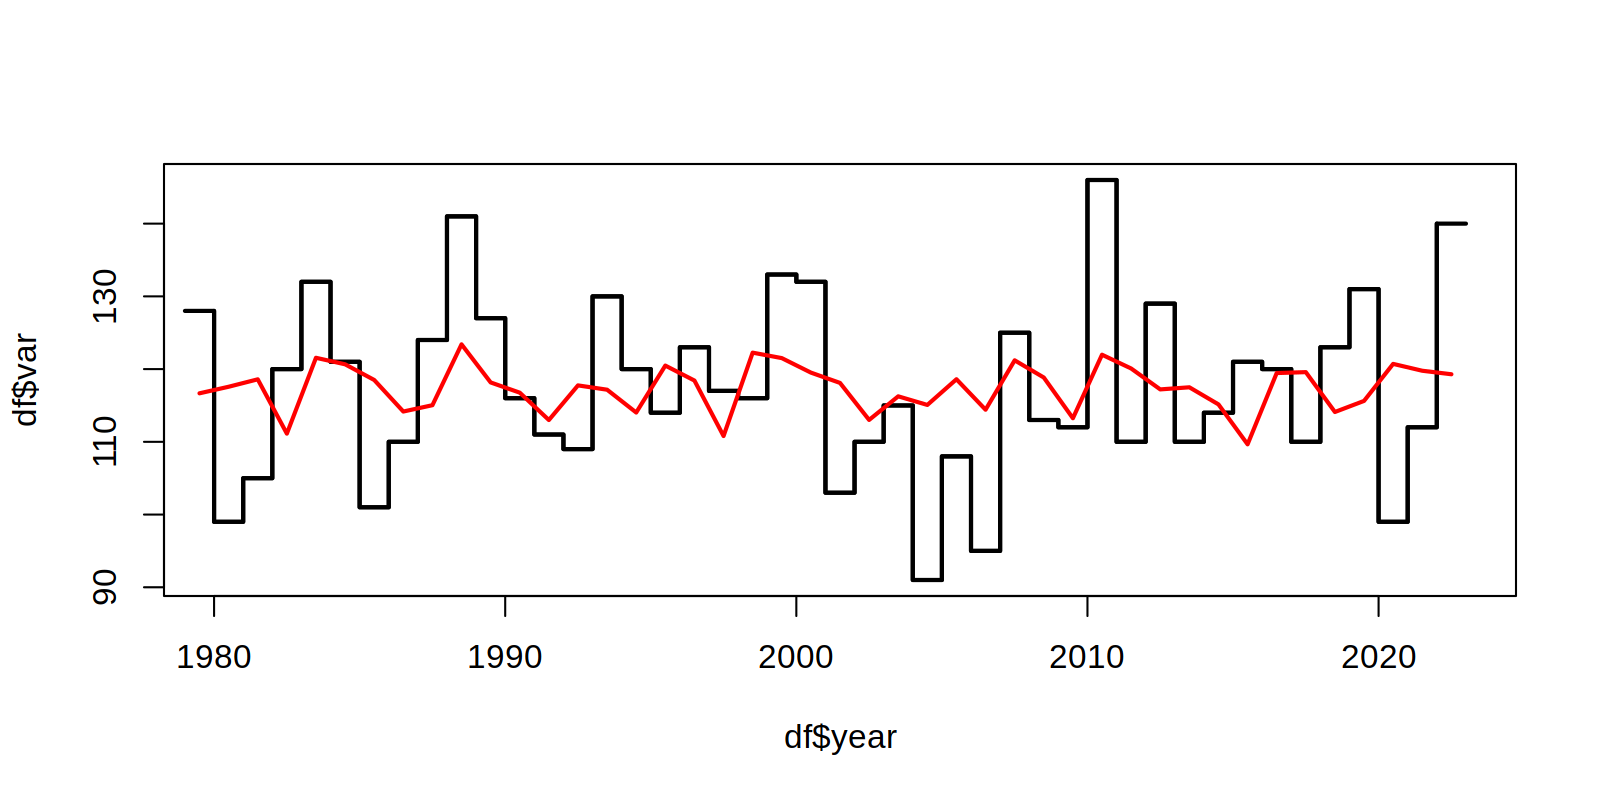

In [85]:
prep_window(c(1,2)); par(mfrow = c(1,1))

plot(df$year, df$var, type = "S", lwd = 2)
lines(df$year-1, df$var, type = "s", lwd = 2)
lines(df$year-0.5, fitted(lm_both), col = "red", lwd = 2)

In [86]:
mdl_ns <- fit_ns("norm", "shift", df, "var", "nino34", lower = F)
nino_2023 <- df$nino34[df$year == 2023]
nino_cf <- 0
ev_2023 <- df$var[df$year == 2023]

# 'official' end of rainy season is December 27th - day 360

In [87]:
# return period of 2023 season end in current & neutral Nino phases 
rp_2023 <- return_period(mdl_ns, ev_2023, fixed_cov = nino_2023)
rp_neut <- return_period(mdl_ns, ev_2023, fixed_cov = nino_cf)

# unconditional return period of 2023 early end of rainy season
rp_unc <- 1/(mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = ev_2023, fixed_cov = i) })))

print(c("nino" = rp_2023, "neutral" = rp_neut, "unconditional" = rp_unc))

         nino       neutral unconditional 
     21.45881      38.04716      31.52823 


In [88]:
# compare expected & observed number of exeedances
print(round(c("expected" = mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = ev_2023, fixed_cov = i) })) * nrow(df),
              "observed" = sum(df$var <= ev_2023)), 2))

expected observed 
     1.4     42.0 


In [89]:
# compare expected & observed number of early-finishing rainy seasons
print(round(c("expected" = mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = 360, fixed_cov = i) })) * nrow(df),
              "observed" = sum(df$var <= 360)), 2))

expected observed 
       0       44 


In [90]:
# probability that rainy season will finish early
prob_ratio(mdl_ns, 360, cov = nino_2023, cov_cf = nino_cf)

[1] 207.9234

In [91]:
# and how much later is the rainy season expected to start this year vs a neutral year?
int_change(mdl_ns, cov = nino_2023, cov_cf = nino_cf)

[1] 3.056789

## End of rainy season

In [ ]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
ts <- read.fwf("ts/panama-drought_mswep_rs-ends.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "var"))

df <- merge(merge(gmst, nino), ts)

In [78]:
ks.test(scale(df$var+rnorm(nrow(df),0,0.1)), pnorm) # jitter points to avoid error due to ties


	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$var + rnorm(nrow(df), 0, 0.1))
D = 0.090926, p-value = 0.8183
alternative hypothesis: two-sided


In [79]:
lm_s <- lm(var ~ 1, data = df)
lm_gmst <- lm(var ~ gmst, data = df)
lm_nino <- lm(var ~ nino34, data = df)
lm_both <- lm(var ~ gmst + nino34, data = df)
lm_int <- lm(var ~ gmst * nino34, data = df)

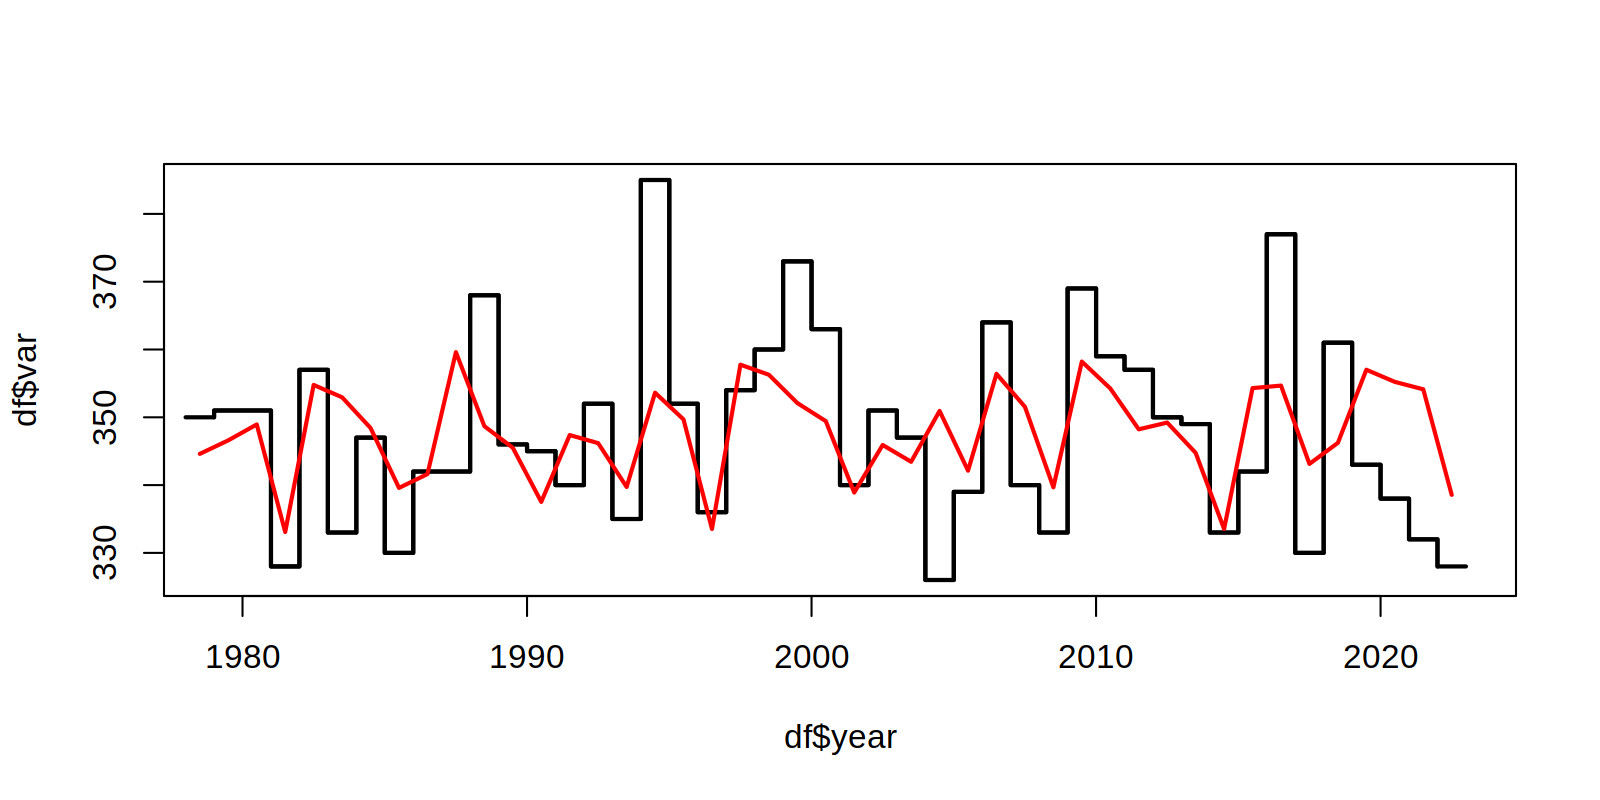

In [102]:
prep_window(c(1,2)); par(mfrow = c(1,1))

plot(df$year, df$var, type = "S", lwd = 2)
lines(df$year-1, df$var, type = "s", lwd = 2)
lines(df$year-0.5, fitted(lm_nino), col = "red", lwd = 2)

In [121]:
mdl_ns <- fit_ns("norm", "shift", df, "var", "nino34", lower = T)
nino_2023 <- df$nino34[df$year == 2023]
nino_cf <- 0
ev_2023 <- df$var[df$year == 2023]

# 'official' end of rainy season is December 27th - day 360

In [146]:
# return period of 2023 season end in current & neutral Nino phases 
rp_2023 <- return_period(mdl_ns, ev_2023, fixed_cov = nino_2023)
rp_neut <- return_period(mdl_ns, ev_2023, fixed_cov = nino_cf)

# unconditional return period of 2023 early end of rainy season
rp_unc <- 1/(mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = ev_2023, fixed_cov = i) })))

print(c("nino" = rp_2023, "neutral" = rp_neut, "unconditional" = rp_unc))

         nino       neutral unconditional 
     5.353465     19.722468     12.826661 


In [152]:
# compare expected & observed number of exeedances
print(round(c("expected" = mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = ev_2023, fixed_cov = i) })) * nrow(df),
              "observed" = sum(df$var <= ev_2023)), 2))

expected observed 
    3.51     3.00 


In [155]:
# compare expected & observed number of early-finishing rainy seasons
print(round(c("expected" = mean(sapply(df$nino34, function(i) { 1/return_period(mdl_ns, x = 360, fixed_cov = i) })) * nrow(df),
              "observed" = sum(df$var <= 360)), 2))

expected observed 
   36.53    37.00 


In [165]:
# probability that rainy season will finish early
prob_ratio(mdl_ns, 360, cov = nino_2023, cov_cf = nino_cf)

[1] 1.128401

In [167]:
# and how much earlier is the rainy season expected to end this year vs a neutral year?
int_change(mdl_ns, cov = nino_2023, cov_cf = nino_cf)

[1] -8.88511

## Duration of rainy season

## Precipitation (incl Nino - old data, needs updating)

In [4]:
mswep = read.csv(paste0("data/mswep_monthly.csv"))
mswep$pr6m = filter(mswep$pr, rep(1,6), sides = 1)
mswep$year <- as.integer(substr(mswep$time,1,4))
mswep$month <- as.integer(substr(mswep$time,6,7))

nino <- read.csv("data/nino34rel_accum.csv")
nino$year <- as.integer(substr(nino$time,1,4))
nino$month <- as.integer(substr(nino$time,6,7))

gmst <- read.fwf("../../Data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

Warning message in file(file, "rt"):
“cannot open file 'data/mswep_monthly.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection
